# Partie 3 : Analyse comparative et optimisation

## A - Evaluation multi-modèles

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM, T5ForConditionalGeneration
)
import time
import psutil
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

/home/arthur/Deep Learning/tp_transformers/.venv/Scripts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")

Device utilisé: cpu


## Modèles de classification

In [4]:
# DistilBERT-base-uncased
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
distilbert_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
test_texts = [
    "I love this product, it's amazing and works perfectly!",
    "This is terrible, worst experience ever, completely disappointed",
    "Great service and excellent quality, highly recommend",
    "Disappointing results, not recommended, poor performance",
    "Outstanding performance, very satisfied with the purchase",
    "Poor quality, waste of money, regret buying this",
    "Excellent customer support, very helpful staff",
    "Very frustrating experience, technical issues everywhere",
    "Best purchase I've ever made, exceeded expectations",
    "Completely useless product, doesn't work as advertised",
    "Good value for money, decent quality overall",
    "Horrible customer service, unhelpful and rude staff",
    "Amazing features, easy to use, great design",
    "Faulty product, broke after one week of use",
    "Impressive results, better than expected quality"
]

test_labels = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

In [7]:
long_texts = [
    "This is a longer text to test the performance of both models on extended sequences. " * 10,
    "Another extended text sample that contains multiple sentences and should provide insights into model efficiency. " * 10,
    "Testing computational efficiency with longer input sequences to understand the trade-offs between model size and performance. " * 10
]

In [8]:
def measure_inference_time(model, tokenizer, texts, num_runs=3):
    """Mesure le temps d'inférence avec plusieurs runs"""
    all_times = []

    for _ in range(num_runs):
        times = []
        for text in texts:
            start_time = time.time()

            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
            with torch.no_grad():
                outputs = model(**inputs)

            end_time = time.time()
            times.append(end_time - start_time)

            # Nettoyage mémoire
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

        all_times.extend(times)

    return all_times

In [9]:
def get_model_size(model):
    """Calcule la taille du modèle en MB"""
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / 1024**2

In [10]:
def count_parameters(model):
    """Compte le nombre de paramètres"""
    return sum(p.numel() for p in model.parameters())

In [11]:
def get_memory_usage():
    """Obtient l'utilisation mémoire actuelle"""
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / 1024**2  # MB
    else:
        return psutil.Process().memory_info().rss / 1024**2  # MB

In [12]:
def evaluate_model(model, tokenizer, texts, labels):
    """Évalue les performances du modèle"""
    predictions = []
    confidences = []

    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)
            prediction = torch.argmax(outputs.logits, dim=-1).item()
            confidence = torch.max(probs).item()

            predictions.append(prediction)
            confidences.append(confidence)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    avg_confidence = np.mean(confidences)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'avg_confidence': avg_confidence,
        'predictions': predictions
    }

In [13]:
print("\n=== ÉVALUATION DISTILBERT-BASE-UNCASED ===")

# Métriques de base
distilbert_params = count_parameters(distilbert_model)
distilbert_size = get_model_size(distilbert_model)

# Performance sur textes courts
distilbert_times_short = measure_inference_time(distilbert_model, distilbert_tokenizer, test_texts)
distilbert_results = evaluate_model(distilbert_model, distilbert_tokenizer, test_texts, test_labels)

# Performance sur textes longs
distilbert_times_long = measure_inference_time(distilbert_model, distilbert_tokenizer, long_texts)

print(f"DistilBERT - Nombre de paramètres: {distilbert_params:,}")
print(f"DistilBERT - Taille du modèle: {distilbert_size:.2f} MB")
print(f"DistilBERT - Temps moyen (textes courts): {np.mean(distilbert_times_short):.4f}s")
print(f"DistilBERT - Temps moyen (textes longs): {np.mean(distilbert_times_long):.4f}s")
print(f"DistilBERT - Accuracy: {distilbert_results['accuracy']:.3f}")
print(f"DistilBERT - F1-Score: {distilbert_results['f1']:.3f}")
print(f"DistilBERT - Confiance moyenne: {distilbert_results['avg_confidence']:.3f}")


=== ÉVALUATION DISTILBERT-BASE-UNCASED ===


/home/arthur/Deep Learning/tp_transformers/.venv/Scripts/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


DistilBERT - Nombre de paramètres: 66,955,010
DistilBERT - Taille du modèle: 255.42 MB
DistilBERT - Temps moyen (textes courts): 0.0413s
DistilBERT - Temps moyen (textes longs): 0.0674s
DistilBERT - Accuracy: 0.467
DistilBERT - F1-Score: 0.000
DistilBERT - Confiance moyenne: 0.546


In [14]:
print("\n=== ÉVALUATION BERT-BASE-UNCASED ===")

# Métriques de base
bert_params = count_parameters(bert_model)
bert_size = get_model_size(bert_model)

# Performance sur textes courts
bert_times_short = measure_inference_time(bert_model, bert_tokenizer, test_texts)
bert_results = evaluate_model(bert_model, bert_tokenizer, test_texts, test_labels)

# Performance sur textes longs
bert_times_long = measure_inference_time(bert_model, bert_tokenizer, long_texts)

print(f"BERT - Nombre de paramètres: {bert_params:,}")
print(f"BERT - Taille du modèle: {bert_size:.2f} MB")
print(f"BERT - Temps moyen (textes courts): {np.mean(bert_times_short):.4f}s")
print(f"BERT - Temps moyen (textes longs): {np.mean(bert_times_long):.4f}s")
print(f"BERT - Accuracy: {bert_results['accuracy']:.3f}")
print(f"BERT - F1-Score: {bert_results['f1']:.3f}")
print(f"BERT - Confiance moyenne: {bert_results['avg_confidence']:.3f}")


=== ÉVALUATION BERT-BASE-UNCASED ===
BERT - Nombre de paramètres: 109,483,778
BERT - Taille du modèle: 417.66 MB
BERT - Temps moyen (textes courts): 0.0769s
BERT - Temps moyen (textes longs): 0.0878s
BERT - Accuracy: 0.533
BERT - F1-Score: 0.696
BERT - Confiance moyenne: 0.669


In [15]:
comparison_data = {
    'Modèle': ['DistilBERT-base-uncased', 'BERT-base-uncased'],
    'Paramètres (M)': [distilbert_params/1e6, bert_params/1e6],
    'Taille (MB)': [distilbert_size, bert_size],
    'Temps inf. courts (s)': [np.mean(distilbert_times_short), np.mean(bert_times_short)],
    'Temps inf. longs (s)': [np.mean(distilbert_times_long), np.mean(bert_times_long)],
    'Accuracy': [distilbert_results['accuracy'], bert_results['accuracy']],
    'F1-Score': [distilbert_results['f1'], bert_results['f1']],
    'Precision': [distilbert_results['precision'], bert_results['precision']],
    'Recall': [distilbert_results['recall'], bert_results['recall']],
    'Confiance moy.': [distilbert_results['avg_confidence'], bert_results['avg_confidence']]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n=== TABLEAU COMPARATIF ===")
print(df_comparison.round(4))


=== TABLEAU COMPARATIF ===
                    Modèle  Paramètres (M)  Taille (MB)  \
0  DistilBERT-base-uncased         66.9550     255.4170   
1        BERT-base-uncased        109.4838     417.6553   

   Temps inf. courts (s)  Temps inf. longs (s)  Accuracy  F1-Score  Precision  \
0                 0.0413                0.0674    0.4667    0.0000     0.0000   
1                 0.0769                0.0878    0.5333    0.6957     0.5333   

   Recall  Confiance moy.  
0     0.0          0.5457  
1     1.0          0.6686  


In [16]:
# Ratio efficacité (performance/temps)
distilbert_efficiency = distilbert_results['f1'] / np.mean(distilbert_times_short)
bert_efficiency = bert_results['f1'] / np.mean(bert_times_short)

# Ratio compression (performance/taille)
distilbert_compression = distilbert_results['f1'] / distilbert_size
bert_compression = bert_results['f1'] / bert_size

print(f"\n=== RATIOS PERFORMANCE ===")
print(f"DistilBERT - Efficacité (F1/temps): {distilbert_efficiency:.2f}")
print(f"BERT - Efficacité (F1/temps): {bert_efficiency:.2f}")
print(f"DistilBERT - Compression (F1/taille): {distilbert_compression:.4f}")
print(f"BERT - Compression (F1/taille): {bert_compression:.4f}")


=== RATIOS PERFORMANCE ===
DistilBERT - Efficacité (F1/temps): 0.00
BERT - Efficacité (F1/temps): 9.05
DistilBERT - Compression (F1/taille): 0.0000
BERT - Compression (F1/taille): 0.0017


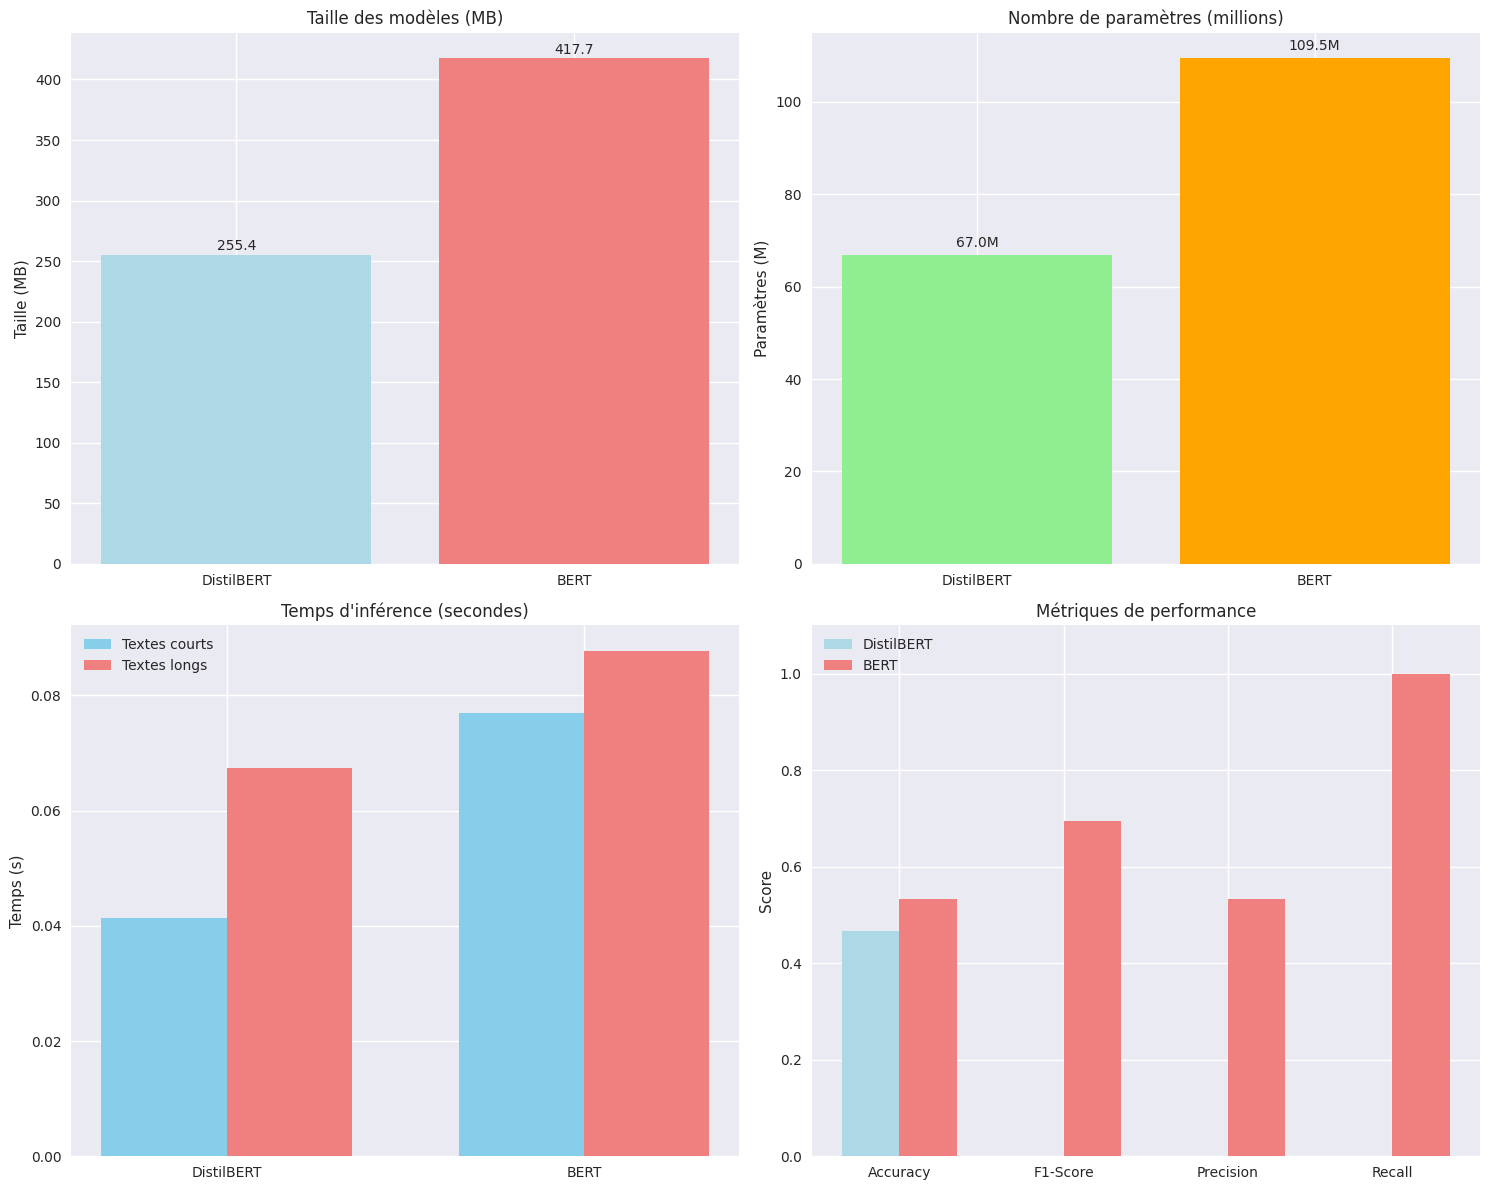

In [17]:
# Configuration des graphiques
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Comparaison des tailles
models = ['DistilBERT', 'BERT']
sizes = [distilbert_size, bert_size]
params = [distilbert_params/1e6, bert_params/1e6]

axes[0,0].bar(models, sizes, color=['lightblue', 'lightcoral'])
axes[0,0].set_title('Taille des modèles (MB)')
axes[0,0].set_ylabel('Taille (MB)')
for i, v in enumerate(sizes):
    axes[0,0].text(i, v + 1, f'{v:.1f}', ha='center', va='bottom')

# 2. Comparaison du nombre de paramètres
axes[0,1].bar(models, params, color=['lightgreen', 'orange'])
axes[0,1].set_title('Nombre de paramètres (millions)')
axes[0,1].set_ylabel('Paramètres (M)')
for i, v in enumerate(params):
    axes[0,1].text(i, v + 1, f'{v:.1f}M', ha='center', va='bottom')

# 3. Temps d'inférence
times_short = [np.mean(distilbert_times_short), np.mean(bert_times_short)]
times_long = [np.mean(distilbert_times_long), np.mean(bert_times_long)]

x = np.arange(len(models))
width = 0.35

axes[1,0].bar(x - width/2, times_short, width, label='Textes courts', color='skyblue')
axes[1,0].bar(x + width/2, times_long, width, label='Textes longs', color='lightcoral')
axes[1,0].set_title('Temps d\'inférence (secondes)')
axes[1,0].set_ylabel('Temps (s)')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(models)
axes[1,0].legend()

# 4. Métriques de performance
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
distilbert_metrics = [distilbert_results['accuracy'], distilbert_results['f1'],
                     distilbert_results['precision'], distilbert_results['recall']]
bert_metrics = [bert_results['accuracy'], bert_results['f1'],
               bert_results['precision'], bert_results['recall']]

x = np.arange(len(metrics))
axes[1,1].bar(x - width/2, distilbert_metrics, width, label='DistilBERT', color='lightblue')
axes[1,1].bar(x + width/2, bert_metrics, width, label='BERT', color='lightcoral')
axes[1,1].set_title('Métriques de performance')
axes[1,1].set_ylabel('Score')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(metrics)
axes[1,1].legend()
axes[1,1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

In [18]:
print("\n=== ANALYSE DES TRADE-OFFS ===")
print(f"Réduction de taille: {((bert_size - distilbert_size) / bert_size * 100):.1f}%")
print(f"Réduction de paramètres: {((bert_params - distilbert_params) / bert_params * 100):.1f}%")
print(f"Gain de vitesse (textes courts): {(np.mean(bert_times_short) / np.mean(distilbert_times_short)):.2f}x")
print(f"Gain de vitesse (textes longs): {(np.mean(bert_times_long) / np.mean(distilbert_times_long)):.2f}x")
print(f"Différence de performance F1: {(bert_results['f1'] - distilbert_results['f1']):.3f}")

# Forces et faiblesses
print("\n=== FORCES ET FAIBLESSES ===")
print("\nDistilBERT:")
print("+ Plus rapide et léger")
print("+ Moins de mémoire requise")
print("+ Bon pour déploiement mobile/edge")
if distilbert_results['f1'] >= bert_results['f1']:
    print("+ Performance équivalente ou supérieure")
else:
    print("- Performance légèrement inférieure")

print("\nBERT:")
print("+ Modèle de référence, bien testé")
print("+ Potentiellement plus stable")
if bert_results['f1'] > distilbert_results['f1']:
    print("+ Meilleure performance")
else:
    print("- Performance équivalente")
print("- Plus lent et plus lourd")
print("- Plus de ressources requises")


=== ANALYSE DES TRADE-OFFS ===
Réduction de taille: 38.8%
Réduction de paramètres: 38.8%
Gain de vitesse (textes courts): 1.86x
Gain de vitesse (textes longs): 1.30x
Différence de performance F1: 0.696

=== FORCES ET FAIBLESSES ===

DistilBERT:
+ Plus rapide et léger
+ Moins de mémoire requise
+ Bon pour déploiement mobile/edge
- Performance légèrement inférieure

BERT:
+ Modèle de référence, bien testé
+ Potentiellement plus stable
+ Meilleure performance
- Plus lent et plus lourd
- Plus de ressources requises


## Modèles de génération de texte

In [19]:
try:
    import sentencepiece
    print("SentencePiece importé avec succès!")
    print(f"Version: {sentencepiece.__version__}")
except ImportError as e:
    print(f"Erreur d'import: {e}")

Erreur d'import: No module named 'sentencepiece'


In [23]:
gpt2_tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
gpt2_model = AutoModelForCausalLM.from_pretrained("distilgpt2").to(device)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# T5-small
t5_tokenizer = AutoTokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

In [24]:
# Prompts pour génération libre (GPT2)
generation_prompts = [
    "The future of artificial intelligence is",
    "Climate change affects our planet by",
    "Technology has revolutionized the way we",
    "In the next decade, we will see",
    "The most important scientific discovery",
    "Social media platforms have changed",
    "Renewable energy sources are becoming",
    "Space exploration continues to reveal"
]

# Tâches pour T5 (format text-to-text)
t5_tasks = [
    "summarize: Artificial intelligence is rapidly advancing and transforming various industries. Machine learning algorithms are becoming more sophisticated, enabling computers to perform tasks that were once thought to be exclusively human. From healthcare to transportation, AI is revolutionizing how we work and live.",
    "translate English to French: Hello, how are you today?",
    "question: What is the capital of France? context: Paris is the capital and most populous city of France.",
    "summarize: Climate change is one of the most pressing issues of our time. Rising temperatures, melting ice caps, and extreme weather events are clear indicators of our changing climate. Scientists worldwide are working to understand and mitigate these effects.",
    "translate English to German: I love learning new languages.",
    "question: What causes climate change? context: Climate change is primarily caused by human activities such as burning fossil fuels, deforestation, and industrial processes.",
    "summarize: Technology has transformed education through online learning platforms, digital resources, and interactive tools. Students can now access information instantly and learn at their own pace.",
    "translate English to Spanish: The weather is beautiful today."
]

# Textes de référence pour évaluation
reference_texts = [
    "AI advances rapidly, transforming industries through sophisticated machine learning.",
    "Bonjour, comment allez-vous aujourd'hui?",
    "Paris",
    "Climate change presents urgent challenges with rising temperatures and extreme weather.",
    "Ich liebe es, neue Sprachen zu lernen.",
    "Human activities like burning fossil fuels cause climate change.",
    "Technology transforms education through online platforms and digital tools.",
    "El clima está hermoso hoy."
]

In [25]:
def calculate_perplexity(model, tokenizer, texts, is_t5=False):
    """Calcule la perplexité"""
    perplexities = []

    for text in texts:
        if is_t5:
            # Pour T5, on utilise une tâche de génération
            input_text = f"generate: {text}"
            inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)
            labels = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

            with torch.no_grad():
                outputs = model(**inputs, labels=labels.input_ids)
                loss = outputs.loss.item()
        else:
            # Pour GPT2
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

            with torch.no_grad():
                outputs = model(**inputs, labels=inputs.input_ids)
                loss = outputs.loss.item()

        perplexity = math.exp(loss)
        perplexities.append(perplexity)

    return perplexities

In [26]:
def measure_generation_time(model, tokenizer, prompts, is_t5=False, max_length=50):
    """Mesure le temps de génération"""
    times = []
    generated_texts = []

    for prompt in prompts:
        start_time = time.time()

        if is_t5:
            inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_length=max_length,
                    num_return_sequences=1,
                    do_sample=True,
                    temperature=0.7,
                    pad_token_id=tokenizer.pad_token_id
                )
            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        else:
            inputs = tokenizer(prompt, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_length=len(inputs.input_ids[0]) + max_length,
                    num_return_sequences=1,
                    do_sample=True,
                    temperature=0.7,
                    pad_token_id=tokenizer.eos_token_id
                )
            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        end_time = time.time()
        times.append(end_time - start_time)
        generated_texts.append(generated_text)

        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return times, generated_texts


In [27]:
from rouge_score import rouge_scorer

def calculate_rouge_scores(generated_texts, reference_texts):
    """Calcule les scores ROUGE"""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for gen, ref in zip(generated_texts, reference_texts):
        scores = scorer.score(ref, gen)
        rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

    return {
        'rouge1': np.mean(rouge_scores['rouge1']),
        'rouge2': np.mean(rouge_scores['rouge2']),
        'rougeL': np.mean(rouge_scores['rougeL'])
    }

In [28]:
from collections import Counter

def calculate_diversity_metrics(texts):
    """Calcule les métriques de diversité"""
    all_tokens = []
    for text in texts:
        tokens = text.lower().split()
        all_tokens.extend(tokens)

    # Vocabulaire unique
    unique_tokens = len(set(all_tokens))
    total_tokens = len(all_tokens)

    # Type-Token Ratio (TTR)
    ttr = unique_tokens / total_tokens if total_tokens > 0 else 0

    # Entropie
    token_counts = Counter(all_tokens)
    probs = [count / total_tokens for count in token_counts.values()]
    entropy = -sum(p * math.log2(p) for p in probs if p > 0)

    return {
        'unique_tokens': unique_tokens,
        'total_tokens': total_tokens,
        'ttr': ttr,
        'entropy': entropy
    }

In [29]:
print("\n=== ÉVALUATION DISTILGPT2 ===")

# Métriques de base
gpt2_params = count_parameters(gpt2_model)
gpt2_size = get_model_size(gpt2_model)

# Génération et temps
gpt2_times, gpt2_generations = measure_generation_time(gpt2_model, gpt2_tokenizer, generation_prompts, is_t5=False)

# Perplexité sur les prompts
gpt2_perplexities = calculate_perplexity(gpt2_model, gpt2_tokenizer, generation_prompts[:5], is_t5=False)

# Métriques de diversité
gpt2_diversity = calculate_diversity_metrics(gpt2_generations)

print(f"DistilGPT2 - Nombre de paramètres: {gpt2_params:,}")
print(f"DistilGPT2 - Taille du modèle: {gpt2_size:.2f} MB")
print(f"DistilGPT2 - Temps moyen de génération: {np.mean(gpt2_times):.4f}s")
print(f"DistilGPT2 - Perplexité moyenne: {np.mean(gpt2_perplexities):.2f}")
print(f"DistilGPT2 - TTR (diversité): {gpt2_diversity['ttr']:.3f}")
print(f"DistilGPT2 - Entropie: {gpt2_diversity['entropy']:.2f}")

# Affichage d'exemples de génération
print("\nExemples de génération DistilGPT2:")
for i, (prompt, gen) in enumerate(zip(generation_prompts[:3], gpt2_generations[:3])):
    print(f"{i+1}. Prompt: {prompt}")
    print(f"   Génération: {gen}")
    print()


=== ÉVALUATION DISTILGPT2 ===


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


DistilGPT2 - Nombre de paramètres: 81,912,576
DistilGPT2 - Taille du modèle: 318.47 MB
DistilGPT2 - Temps moyen de génération: 1.7274s
DistilGPT2 - Perplexité moyenne: 168.82
DistilGPT2 - TTR (diversité): 0.417
DistilGPT2 - Entropie: 5.97

Exemples de génération DistilGPT2:
1. Prompt: The future of artificial intelligence is
   Génération: The future of artificial intelligence is not in the realms of Artificial Intelligence, but in the realms of Artificial Intelligence. It is in the realm of Artificial Intelligence. It is in the realm of Artificial Intelligence. It is in the realm of Artificial Intelligence. It is in the realm of Artificial

2. Prompt: Climate change affects our planet by
   Génération: Climate change affects our planet by releasing carbon dioxide, heat and heat from the atmosphere, the Earth›, and changing atmospheric conditions.






























3. Prompt: Technology has revolutionized the way we
   Génération: Technology has revolutionized the way we us

In [30]:
print("\n=== ÉVALUATION T5-SMALL ===")

# Métriques de base
t5_params = count_parameters(t5_model)
t5_size = get_model_size(t5_model)

# Génération et temps
t5_times, t5_generations = measure_generation_time(t5_model, t5_tokenizer, t5_tasks, is_t5=True)

# Scores ROUGE par rapport aux références
t5_rouge = calculate_rouge_scores(t5_generations, reference_texts)

# Métriques de diversité
t5_diversity = calculate_diversity_metrics(t5_generations)

print(f"T5-small - Nombre de paramètres: {t5_params:,}")
print(f"T5-small - Taille du modèle: {t5_size:.2f} MB")
print(f"T5-small - Temps moyen de génération: {np.mean(t5_times):.4f}s")
print(f"T5-small - ROUGE-1: {t5_rouge['rouge1']:.3f}")
print(f"T5-small - ROUGE-2: {t5_rouge['rouge2']:.3f}")
print(f"T5-small - ROUGE-L: {t5_rouge['rougeL']:.3f}")
print(f"T5-small - TTR (diversité): {t5_diversity['ttr']:.3f}")
print(f"T5-small - Entropie: {t5_diversity['entropy']:.2f}")

# Affichage d'exemples de génération
print("\nExemples de génération T5-small:")
for i, (task, gen) in enumerate(zip(t5_tasks[:3], t5_generations[:3])):
    print(f"{i+1}. Tâche: {task}")
    print(f"   Génération: {gen}")
    print(f"   Référence: {reference_texts[i]}")
    print()


=== ÉVALUATION T5-SMALL ===
T5-small - Nombre de paramètres: 60,506,624
T5-small - Taille du modèle: 230.81 MB
T5-small - Temps moyen de génération: 0.1856s
T5-small - ROUGE-1: 0.474
T5-small - ROUGE-2: 0.200
T5-small - ROUGE-L: 0.444
T5-small - TTR (diversité): 0.918
T5-small - Entropie: 6.02

Exemples de génération T5-small:
1. Tâche: summarize: Artificial intelligence is rapidly advancing and transforming various industries. Machine learning algorithms are becoming more sophisticated, enabling computers to perform tasks that were once thought to be exclusively human. From healthcare to transportation, AI is revolutionizing how we work and live.
   Génération: machine learning algorithms are becoming more sophisticated. computers can perform tasks that were once thought to be exclusively human.
   Référence: AI advances rapidly, transforming industries through sophisticated machine learning.

2. Tâche: translate English to French: Hello, how are you today?
   Génération: Bonjour, co

In [31]:
print("\n=== COMPARAISON SUR TÂCHE DE COMPLÉTION ===")

# Prompts communs pour comparaison
common_prompts = [
    "The benefits of renewable energy include",
    "Artificial intelligence will help us",
    "The future of space exploration"
]

# Génération GPT2
gpt2_common_times, gpt2_common_gens = measure_generation_time(gpt2_model, gpt2_tokenizer, common_prompts, is_t5=False, max_length=30)

# Génération T5 (conversion en format text-to-text)
t5_common_prompts = [f"generate: {prompt}" for prompt in common_prompts]
t5_common_times, t5_common_gens = measure_generation_time(t5_model, t5_tokenizer, t5_common_prompts, is_t5=True, max_length=30)

print("Comparaison directe:")
for i, prompt in enumerate(common_prompts):
    print(f"\nPrompt: {prompt}")
    print(f"GPT2 ({gpt2_common_times[i]:.3f}s): {gpt2_common_gens[i]}")
    print(f"T5 ({t5_common_times[i]:.3f}s): {t5_common_gens[i]}")


=== COMPARAISON SUR TÂCHE DE COMPLÉTION ===
Comparaison directe:

Prompt: The benefits of renewable energy include
GPT2 (0.662s): The benefits of renewable energy include the ability to drive clean energy, and the ability to reduce carbon pollution. These include the ability to reduce the cost of electricity by reducing the consumption of
T5 (0.035s): Energie

Prompt: Artificial intelligence will help us
GPT2 (0.641s): Artificial intelligence will help us to become more complex, more intelligent, more intelligent, more intelligent, and more intelligent, and more intelligent, and more intelligent, and more intelligent,
T5 (0.108s): generate: artificial intelligence will help us

Prompt: The future of space exploration
GPT2 (0.614s): The future of space exploration will depend on a number of factors. These include the fact that the current atmosphere is being cooled by solar-powered particles, because this will reduce the
T5 (0.125s): d gener: The future of space exploration


In [32]:
comparison_data = {
    'Modèle': ['DistilGPT2', 'T5-small'],
    'Paramètres (M)': [gpt2_params/1e6, t5_params/1e6],
    'Taille (MB)': [gpt2_size, t5_size],
    'Temps génération (s)': [np.mean(gpt2_times), np.mean(t5_times)],
    'Architecture': ['Decoder-only', 'Encoder-Decoder'],
    'Diversité (TTR)': [gpt2_diversity['ttr'], t5_diversity['ttr']],
    'Entropie': [gpt2_diversity['entropy'], t5_diversity['entropy']],
    'Cas d\'usage': ['Génération libre', 'Tâches structurées']
}

# Ajout des métriques spécifiques
comparison_data['Métrique qualité'] = [f"Perplexité: {np.mean(gpt2_perplexities):.2f}",
                                      f"ROUGE-L: {t5_rouge['rougeL']:.3f}"]

df_comparison = pd.DataFrame(comparison_data)
print("\n=== TABLEAU COMPARATIF ===")
print(df_comparison)


=== TABLEAU COMPARATIF ===
       Modèle  Paramètres (M)  Taille (MB)  Temps génération (s)  \
0  DistilGPT2       81.912576   318.471703              1.727396   
1    T5-small       60.506624   230.814453              0.185559   

      Architecture  Diversité (TTR)  Entropie         Cas d'usage  \
0     Decoder-only         0.416667  5.966338    Génération libre   
1  Encoder-Decoder         0.917808  6.015100  Tâches structurées   

     Métrique qualité  
0  Perplexité: 168.82  
1      ROUGE-L: 0.444  


In [33]:
print("\n=== ANALYSE DES FORCES ET FAIBLESSES ===")

# Calcul des ratios
gpt2_efficiency = 1 / (np.mean(gpt2_times) * gpt2_size)  # Inverse du produit temps*taille
t5_efficiency = 1 / (np.mean(t5_times) * t5_size)

print(f"\nRatio efficacité globale:")
print(f"DistilGPT2: {gpt2_efficiency:.6f}")
print(f"T5-small: {t5_efficiency:.6f}")

print(f"\nComparaison des tailles:")
print(f"T5-small est {t5_size/gpt2_size:.1f}x plus lourd que DistilGPT2")

print(f"\nComparaison des vitesses:")
print(f"DistilGPT2 est {np.mean(t5_times)/np.mean(gpt2_times):.1f}x plus rapide que T5-small")

print("\n=== FORCES ET FAIBLESSES ===")
print("\nDistilGPT2:")
print("+ Plus rapide et léger")
print("+ Excellent pour génération créative libre")
print("+ Texte fluide et naturel")
print("+ Moins de ressources requises")
print("- Limité aux tâches de génération")
print("- Pas de contrôle de tâche spécifique")
print("- Peut dévier du sujet")

print("\nT5-small:")
print("+ Polyvalent (traduction, résumé, Q&A)")
print("+ Contrôle précis des tâches")
print("+ Architecture encoder-decoder robuste")
print("+ Meilleur pour tâches structurées")
print("- Plus lent et plus lourd")
print("- Nécessite plus de ressources")
print("- Moins naturel pour génération libre")



=== ANALYSE DES FORCES ET FAIBLESSES ===

Ratio efficacité globale:
DistilGPT2: 0.001818
T5-small: 0.023348

Comparaison des tailles:
T5-small est 0.7x plus lourd que DistilGPT2

Comparaison des vitesses:
DistilGPT2 est 0.1x plus rapide que T5-small

=== FORCES ET FAIBLESSES ===

DistilGPT2:
+ Plus rapide et léger
+ Excellent pour génération créative libre
+ Texte fluide et naturel
+ Moins de ressources requises
- Limité aux tâches de génération
- Pas de contrôle de tâche spécifique
- Peut dévier du sujet

T5-small:
+ Polyvalent (traduction, résumé, Q&A)
+ Contrôle précis des tâches
+ Architecture encoder-decoder robuste
+ Meilleur pour tâches structurées
- Plus lent et plus lourd
- Nécessite plus de ressources
- Moins naturel pour génération libre


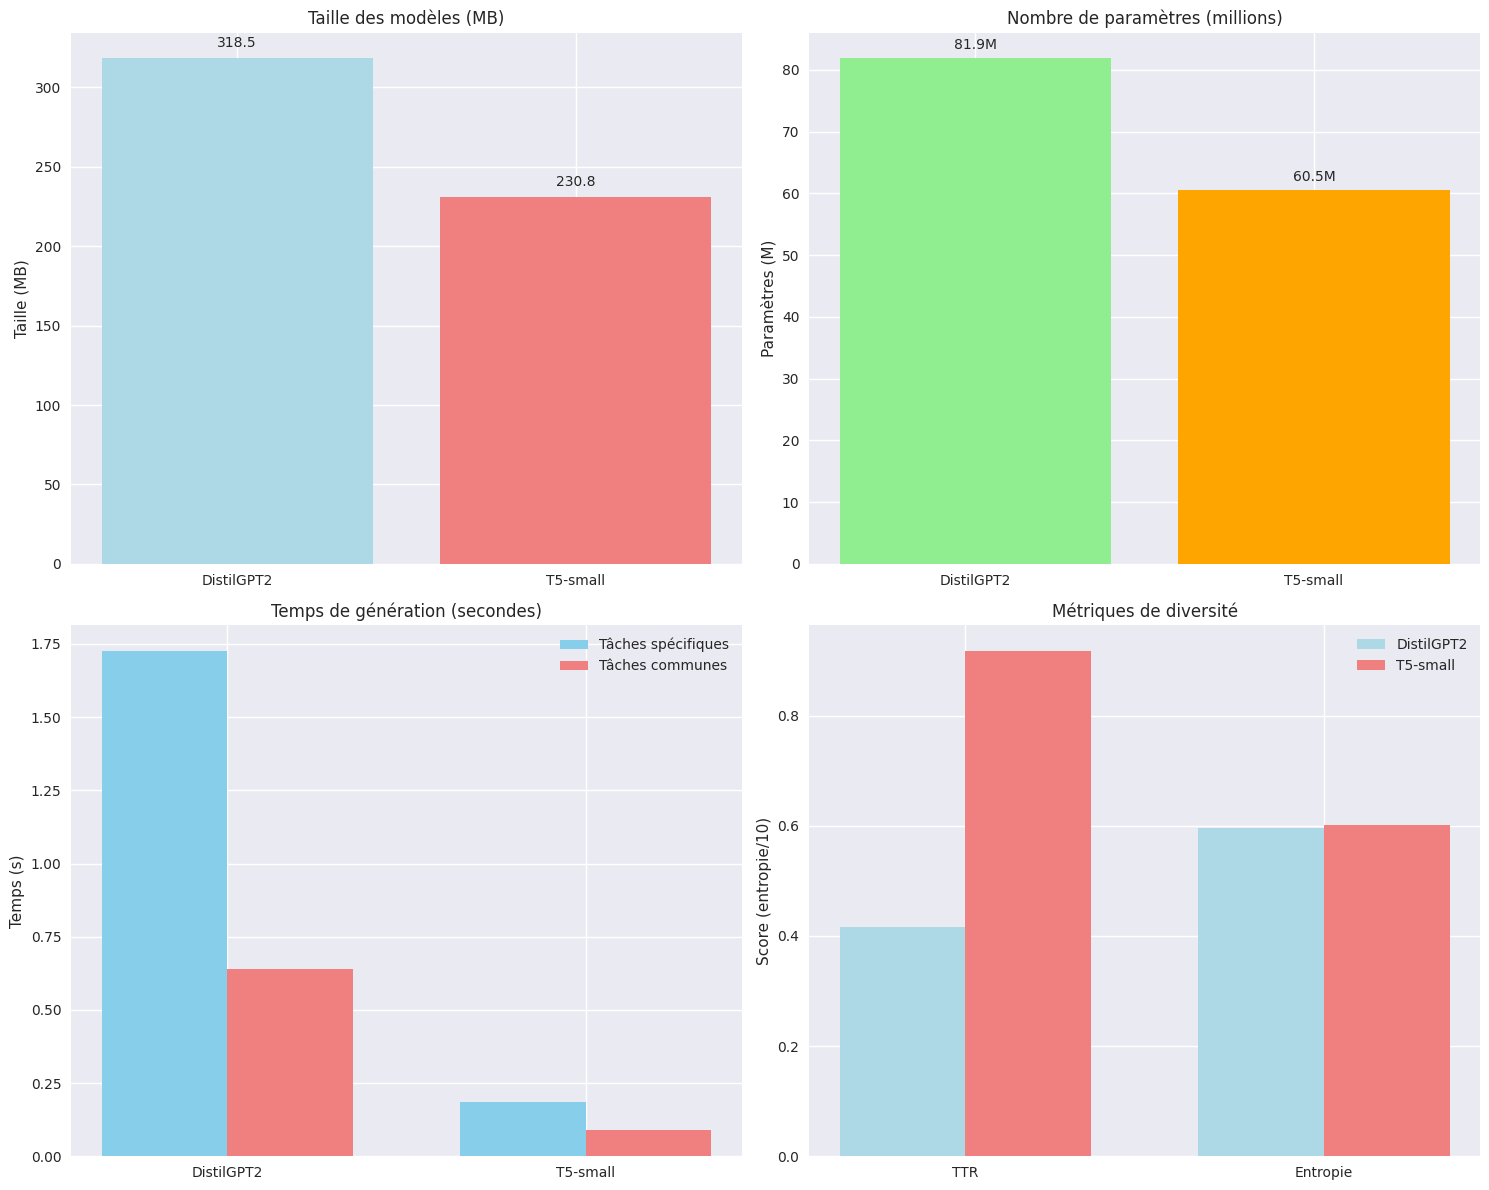

In [34]:
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Comparaison des tailles et paramètres
models = ['DistilGPT2', 'T5-small']
sizes = [gpt2_size, t5_size]
params = [gpt2_params/1e6, t5_params/1e6]

axes[0,0].bar(models, sizes, color=['lightblue', 'lightcoral'])
axes[0,0].set_title('Taille des modèles (MB)')
axes[0,0].set_ylabel('Taille (MB)')
for i, v in enumerate(sizes):
    axes[0,0].text(i, v + 5, f'{v:.1f}', ha='center', va='bottom')

axes[0,1].bar(models, params, color=['lightgreen', 'orange'])
axes[0,1].set_title('Nombre de paramètres (millions)')
axes[0,1].set_ylabel('Paramètres (M)')
for i, v in enumerate(params):
    axes[0,1].text(i, v + 1, f'{v:.1f}M', ha='center', va='bottom')

# 2. Temps de génération
gen_times = [np.mean(gpt2_times), np.mean(t5_times)]
common_times = [np.mean(gpt2_common_times), np.mean(t5_common_times)]

x = np.arange(len(models))
width = 0.35

axes[1,0].bar(x - width/2, gen_times, width, label='Tâches spécifiques', color='skyblue')
axes[1,0].bar(x + width/2, common_times, width, label='Tâches communes', color='lightcoral')
axes[1,0].set_title('Temps de génération (secondes)')
axes[1,0].set_ylabel('Temps (s)')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(models)
axes[1,0].legend()

# 3. Métriques de diversité
diversity_metrics = ['TTR', 'Entropie']
gpt2_div = [gpt2_diversity['ttr'], gpt2_diversity['entropy']/10]  # Normalisation entropie
t5_div = [t5_diversity['ttr'], t5_diversity['entropy']/10]

x = np.arange(len(diversity_metrics))
axes[1,1].bar(x - width/2, gpt2_div, width, label='DistilGPT2', color='lightblue')
axes[1,1].bar(x + width/2, t5_div, width, label='T5-small', color='lightcoral')
axes[1,1].set_title('Métriques de diversité')
axes[1,1].set_ylabel('Score (entropie/10)')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(diversity_metrics)
axes[1,1].legend()

plt.tight_layout()
plt.show()